In [17]:
import numpy as np
from abc import ABC, abstractmethod
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_random_state
from tqdm import tqdm
from sklearn.utils.extmath import randomized_svd, squared_norm
from typing import Any, Optional
from dataclasses import dataclass

from dataclasses import dataclass, field
import numpy as np

from collections import defaultdict
from scipy.optimize import lsq_linear
import matplotlib.pyplot as plt


Array = np.ndarray


def frobenius_norm(s: Array, s_hat: Array) -> float:
    return np.linalg.norm(s - s_hat, ord="fro")

In [2]:
"""
Code for nonnegative least squares by block-pivoting.
"""

import numpy as np
import scipy.sparse as sps
import numpy.linalg as nla

"""
The remaining code in this file was written and shared by Jingu Kim (@kimjingu).
REPO:
----
https://github.com/kimjingu/nonnegfac-python
LICENSE:
-------
Copyright (c) 2014, Nokia Corporation
All rights reserved.
Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:
    * Redistributions of source code must retain the above copyright
      notice, this list of conditions and the following disclaimer.
    * Redistributions in binary form must reproduce the above copyright
      notice, this list of conditions and the following disclaimer in the
      documentation and/or other materials provided with the distribution.
    * Neither the name of the Nokia Corporation nor the
      names of its contributors may be used to endorse or promote products
      derived from this software without specific prior written permission.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL NOKIA CORPORATION BE LIABLE FOR ANY
DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
"""


def nnlsm_blockpivot(A, B, is_input_prod=False, init=None):
    """Nonnegativity-constrained least squares with block principal pivoting method and column grouping
    Solves min ||AX-B||_2^2 s.t. X >= 0 element-wise.
    J. Kim and H. Park, Fast nonnegative matrix factorization: An active-set-like method and comparisons,
    SIAM Journal on Scientific Computing,
    vol. 33, no. 6, pp. 3261-3281, 2011.
    Parameters
    ----------
    A : numpy.array, shape (m,n)
    B : numpy.array or scipy.sparse matrix, shape (m,k)
    Optional Parameters
    -------------------
    is_input_prod : True/False. -  If True, the A and B arguments are interpreted as
            AtA and AtB, respectively. Default is False.
    init: numpy.array, shape (n,k). - If provided, init is used as an initial value for the algorithm.
            Default is None.
    Returns
    -------
    X, (success, Y, num_cholesky, num_eq, num_backup)
    X : numpy.array, shape (n,k) - solution
    success : True/False - True if the solution is found. False if the algorithm did not terminate
            due to numerical errors.
    Y : numpy.array, shape (n,k) - Y = A.T * A * X - A.T * B
    num_cholesky : int - the number of Cholesky factorizations needed
    num_eq : int - the number of linear systems of equations needed to be solved
    num_backup: int - the number of appearances of the back-up rule. See SISC paper for details.
    """
    if is_input_prod:
        AtA = A
        AtB = B
    else:
        AtA = A.T.dot(A)
        if sps.issparse(B):
            AtB = B.T.dot(A)
            AtB = AtB.T
        else:
            AtB = A.T.dot(B)

    (n, k) = AtB.shape
    MAX_ITER = n * 5

    if init is not None:
        PassSet = init > 0
        X, num_cholesky, num_eq = normal_eq_comb(AtA, AtB, PassSet)
        Y = AtA.dot(X) - AtB
    else:
        X = np.zeros([n, k])
        Y = -AtB
        PassSet = np.zeros([n, k], dtype=bool)
        num_cholesky = 0
        num_eq = 0

    p_bar = 3
    p_vec = np.zeros([k])
    p_vec[:] = p_bar
    ninf_vec = np.zeros([k])
    ninf_vec[:] = n + 1
    not_opt_set = np.logical_and(Y < 0, ~PassSet)
    infea_set = np.logical_and(X < 0, PassSet)

    not_good = np.sum(not_opt_set, axis=0) + np.sum(infea_set, axis=0)
    not_opt_colset = not_good > 0
    not_opt_cols = not_opt_colset.nonzero()[0]

    big_iter = 0
    num_backup = 0
    success = True
    while not_opt_cols.size > 0:
        big_iter += 1
        if MAX_ITER > 0 and big_iter > MAX_ITER:
            success = False
            break

        cols_set1 = np.logical_and(not_opt_colset, not_good < ninf_vec)
        temp1 = np.logical_and(not_opt_colset, not_good >= ninf_vec)
        temp2 = p_vec >= 1
        cols_set2 = np.logical_and(temp1, temp2)
        cols_set3 = np.logical_and(temp1, ~temp2)

        cols1 = cols_set1.nonzero()[0]
        cols2 = cols_set2.nonzero()[0]
        cols3 = cols_set3.nonzero()[0]

        if cols1.size > 0:
            p_vec[cols1] = p_bar
            ninf_vec[cols1] = not_good[cols1]
            true_set = np.logical_and(not_opt_set, np.tile(cols_set1, (n, 1)))
            false_set = np.logical_and(infea_set, np.tile(cols_set1, (n, 1)))
            PassSet[true_set] = True
            PassSet[false_set] = False
        if cols2.size > 0:
            p_vec[cols2] = p_vec[cols2] - 1
            temp_tile = np.tile(cols_set2, (n, 1))
            true_set = np.logical_and(not_opt_set, temp_tile)
            false_set = np.logical_and(infea_set, temp_tile)
            PassSet[true_set] = True
            PassSet[false_set] = False
        if cols3.size > 0:
            for col in cols3:
                candi_set = np.logical_or(not_opt_set[:, col], infea_set[:, col])
                to_change = np.max(candi_set.nonzero()[0])
                PassSet[to_change, col] = ~PassSet[to_change, col]
                num_backup += 1

        (X[:, not_opt_cols], temp_cholesky, temp_eq) = normal_eq_comb(
            AtA, AtB[:, not_opt_cols], PassSet[:, not_opt_cols]
        )
        num_cholesky += temp_cholesky
        num_eq += temp_eq
        X[abs(X) < 1e-12] = 0
        Y[:, not_opt_cols] = AtA.dot(X[:, not_opt_cols]) - AtB[:, not_opt_cols]
        Y[abs(Y) < 1e-12] = 0

        not_opt_mask = np.tile(not_opt_colset, (n, 1))
        not_opt_set = np.logical_and(np.logical_and(not_opt_mask, Y < 0), ~PassSet)
        infea_set = np.logical_and(np.logical_and(not_opt_mask, X < 0), PassSet)
        not_good = np.sum(not_opt_set, axis=0) + np.sum(infea_set, axis=0)
        not_opt_colset = not_good > 0
        not_opt_cols = not_opt_colset.nonzero()[0]

    return X, (success, Y, num_cholesky, num_eq, num_backup)


def nnlsm_activeset(A, B, overwrite=False, is_input_prod=False, init=None):
    """Nonnegativity-constrained least squares with active-set method and column grouping
    Solves min ||AX-B||_2^2 s.t. X >= 0 element-wise.
    Algorithm of this routine is close to the one presented in the following paper but
    is different in organising inner- and outer-loops:
    M. H. Van Benthem and M. R. Keenan, J. Chemometrics 2004; 18: 441-450
    Parameters
    ----------
    A : numpy.array, shape (m,n)
    B : numpy.array or scipy.sparse matrix, shape (m,k)
    Optional Parameters
    -------------------
    is_input_prod : True/False. -  If True, the A and B arguments are interpreted as
            AtA and AtB, respectively. Default is False.
    init: numpy.array, shape (n,k). - If provided, init is used as an initial value for the algorithm.
            Default is None.
    Returns
    -------
    X, (success, Y, num_cholesky, num_eq, num_backup)
    X : numpy.array, shape (n,k) - solution
    success : True/False - True if the solution is found. False if the algorithm did not terminate
            due to numerical errors.
    Y : numpy.array, shape (n,k) - Y = A.T * A * X - A.T * B
    num_cholesky : int - the number of Cholesky factorizations needed
    num_eq : int - the number of linear systems of equations needed to be solved
    """
    if is_input_prod:
        AtA = A
        AtB = B
    else:
        AtA = A.T.dot(A)
        if sps.issparse(B):
            AtB = B.T.dot(A)
            AtB = AtB.T
        else:
            AtB = A.T.dot(B)

    (n, k) = AtB.shape
    MAX_ITER = n * 5
    num_cholesky = 0
    num_eq = 0
    not_opt_set = np.ones([k], dtype=bool)

    if overwrite:
        X, num_cholesky, num_eq = normal_eq_comb(AtA, AtB)
        PassSet = X > 0
        not_opt_set = np.any(X < 0, axis=0)
    elif init != None:
        X = init
        X[X < 0] = 0
        PassSet = X > 0
    else:
        X = np.zeros([n, k])
        PassSet = np.zeros([n, k], dtype=bool)

    Y = np.zeros([n, k])
    opt_cols = (~not_opt_set).nonzero()[0]
    not_opt_cols = not_opt_set.nonzero()[0]

    Y[:, opt_cols] = AtA.dot(X[:, opt_cols]) - AtB[:, opt_cols]

    big_iter = 0
    success = True
    while not_opt_cols.size > 0:
        big_iter += 1
        if MAX_ITER > 0 and big_iter > MAX_ITER:
            success = False
            break

        (Z, temp_cholesky, temp_eq) = normal_eq_comb(
            AtA, AtB[:, not_opt_cols], PassSet[:, not_opt_cols]
        )
        num_cholesky += temp_cholesky
        num_eq += temp_eq

        Z[abs(Z) < 1e-12] = 0

        infea_subset = Z < 0
        temp = np.any(infea_subset, axis=0)
        infea_subcols = temp.nonzero()[0]
        fea_subcols = (~temp).nonzero()[0]

        if infea_subcols.size > 0:
            infea_cols = not_opt_cols[infea_subcols]

            (ix0, ix1_subsub) = infea_subset[:, infea_subcols].nonzero()
            ix1_sub = infea_subcols[ix1_subsub]
            ix1 = not_opt_cols[ix1_sub]

            X_infea = X[(ix0, ix1)]

            alpha = np.zeros([n, len(infea_subcols)])
            alpha[:] = np.inf
            alpha[(ix0, ix1_subsub)] = X_infea / (X_infea - Z[(ix0, ix1_sub)])
            min_ix = np.argmin(alpha, axis=0)
            min_vals = alpha[(min_ix, range(0, alpha.shape[1]))]

            X[:, infea_cols] = (
                X[:, infea_cols] + (Z[:, infea_subcols] - X[:, infea_cols]) * min_vals
            )
            X[(min_ix, infea_cols)] = 0
            PassSet[(min_ix, infea_cols)] = False

        elif fea_subcols.size > 0:
            fea_cols = not_opt_cols[fea_subcols]

            X[:, fea_cols] = Z[:, fea_subcols]
            Y[:, fea_cols] = AtA.dot(X[:, fea_cols]) - AtB[:, fea_cols]

            Y[abs(Y) < 1e-12] = 0

            not_opt_subset = np.logical_and(Y[:, fea_cols] < 0, ~PassSet[:, fea_cols])
            new_opt_cols = fea_cols[np.all(~not_opt_subset, axis=0)]
            update_cols = fea_cols[np.any(not_opt_subset, axis=0)]

            if update_cols.size > 0:
                val = Y[:, update_cols] * ~PassSet[:, update_cols]
                min_ix = np.argmin(val, axis=0)
                PassSet[(min_ix, update_cols)] = True

            not_opt_set[new_opt_cols] = False
            not_opt_cols = not_opt_set.nonzero()[0]

    return X, (success, Y, num_cholesky, num_eq)


def normal_eq_comb(AtA, AtB, PassSet=None):
    """Solve many systems of linear equations using combinatorial grouping.
    M. H. Van Benthem and M. R. Keenan, J. Chemometrics 2004; 18: 441-450
    Parameters
    ----------
    AtA : numpy.array, shape (n,n)
    AtB : numpy.array, shape (n,k)
    Returns
    -------
    (Z,num_cholesky,num_eq)
    Z : numpy.array, shape (n,k) - solution
    num_cholesky : int - the number of unique cholesky decompositions done
    num_eq: int - the number of systems of linear equations solved
    """
    num_cholesky = 0
    num_eq = 0
    if AtB.size == 0:
        Z = np.zeros([])
    elif (PassSet is None) or np.all(PassSet):
        Z = nla.solve(AtA, AtB)
        num_cholesky = 1
        num_eq = AtB.shape[1]
    else:
        Z = np.zeros(AtB.shape)
        if PassSet.shape[1] == 1:
            if np.any(PassSet):
                cols = PassSet.nonzero()[0]
                Z[cols] = nla.solve(AtA[np.ix_(cols, cols)], AtB[cols])
                num_cholesky = 1
                num_eq = 1
        else:
            #
            # Both _column_group_loop() and _column_group_recursive() work well.
            # Based on preliminary testing,
            # _column_group_loop() is slightly faster for tiny k(<10), but
            # _column_group_recursive() is faster for large k's.
            #
            grps = _column_group_recursive(PassSet)
            for gr in grps:
                cols = PassSet[:, gr[0]].nonzero()[0]
                if cols.size > 0:
                    ix1 = np.ix_(cols, gr)
                    ix2 = np.ix_(cols, cols)
                    #
                    # scipy.linalg.cho_solve can be used instead of numpy.linalg.solve.
                    # For small n(<200), numpy.linalg.solve appears faster, whereas
                    # for large n(>500), scipy.linalg.cho_solve appears faster.
                    # Usage example of scipy.linalg.cho_solve:
                    # Z[ix1] = sla.cho_solve(sla.cho_factor(AtA[ix2]),AtB[ix1])
                    #
                    Z[ix1] = nla.solve(AtA[ix2], AtB[ix1])
                    num_cholesky += 1
                    num_eq += len(gr)
                    num_eq += len(gr)
    return Z, num_cholesky, num_eq


def _column_group_loop(B):
    """Given a binary matrix, find groups of the same columns
        with a looping strategy
    Parameters
    ----------
    B : numpy.array, True/False in each element
    Returns
    -------
    A list of arrays - each array contain indices of columns that are the same.
    """
    initial = [np.arange(0, B.shape[1])]
    before = initial
    after = []
    for i in range(0, B.shape[0]):
        all_ones = True
        vec = B[i]
        for cols in before:
            if len(cols) == 1:
                after.append(cols)
            else:
                all_ones = False
                subvec = vec[cols]
                trues = subvec.nonzero()[0]
                falses = (~subvec).nonzero()[0]
                if trues.size > 0:
                    after.append(cols[trues])
                if falses.size > 0:
                    after.append(cols[falses])
        before = after
        after = []
        if all_ones:
            break
    return before


def _column_group_recursive(B):
    """Given a binary matrix, find groups of the same columns
        with a recursive strategy
    Parameters
    ----------
    B : numpy.array, True/False in each element
    Returns
    -------
    A list of arrays - each array contain indices of columns that are the same.
    """
    initial = np.arange(0, B.shape[1])
    return [a for a in column_group_sub(B, 0, initial) if len(a) > 0]


def column_group_sub(B, i, cols):
    vec = B[i][cols]
    if len(cols) <= 1:
        return [cols]
    if i == (B.shape[0] - 1):
        col_trues = cols[vec.nonzero()[0]]
        col_falses = cols[(~vec).nonzero()[0]]
        return [col_trues, col_falses]
    else:
        col_trues = cols[vec.nonzero()[0]]
        col_falses = cols[(~vec).nonzero()[0]]
        after = column_group_sub(B, i + 1, col_trues)
        after.extend(column_group_sub(B, i + 1, col_falses))
    return after

In [3]:
def norm(x: Array) -> Array:
    return np.sqrt(squared_norm(x))


def nndsvd(
    x: Array,
    rank: int,
    eps: float = np.finfo(float).eps,
    random_state: Optional[int] = None,
) -> tuple[Array, Array]:
    """adapted from https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/decomposition/_nmf.py"""

    u, s, v = randomized_svd(x, rank, random_state=random_state)
    w = np.zeros_like(u)
    h = np.zeros_like(v)

    # The leading singular triplet is non-negative
    # so it can be used as is for initialization.
    w[:, 0] = np.sqrt(s[0]) * np.abs(u[:, 0])
    h[0, :] = np.sqrt(s[0]) * np.abs(v[0, :])

    for j in range(1, rank):
        x, y = u[:, j], v[j, :]

        # extract positive and negative parts of column vectors
        x_p, y_p = np.maximum(x, 0), np.maximum(y, 0)
        x_n, y_n = np.abs(np.minimum(x, 0)), np.abs(np.minimum(y, 0))

        # and their norms
        x_p_nrm, y_p_nrm = norm(x_p), norm(y_p)
        x_n_nrm, y_n_nrm = norm(x_n), norm(y_n)

        m_p, m_n = x_p_nrm * y_p_nrm, x_n_nrm * y_n_nrm

        # choose update
        if m_p > m_n:
            u_update = x_p / x_p_nrm
            v_update = y_p / y_p_nrm
            sigma = m_p
        else:
            u_update = x_n / x_n_nrm
            v_update = y_n / y_n_nrm
            sigma = m_n

        lbd = np.sqrt(s[j] * sigma)
        w[:, j] = lbd * u_update
        h[j, :] = lbd * v_update

    w[w < eps] = 0
    h[h < eps] = 0

    np.abs(w, out=w)
    np.abs(h, out=h)
    return w, h


@dataclass(kw_only=True)
class BaseNMF(BaseEstimator, TransformerMixin, ABC):
    rank: int = 10
    max_iter: int = 1000
    tol: float = 1e-5
    random_state: Optional[int] = None
    init: str = "random"
    verbose: bool = False
    eps: float = np.finfo(float).eps

    @abstractmethod
    def fit(self, X: Array, y: Optional[Array] = None) -> "BaseNMF":
        """Fit the NMF model."""
        pass

    def init_factor(self, s: Array) -> Array:
        rng = check_random_state(self.random_state)
        if self.init == "random":
            factor = 0.001 * rng.rand(s.shape[0], self.rank)
        elif self.init == "random_sqrt":
            avg = np.sqrt(s.mean() / self.rank)
            factor = rng.rand(s.shape[0], self.rank) * avg
        elif self.init == "nndsvd":
            factor, _ = nndsvd(s, self.rank, self.eps, self.random_state)
        elif self.init == "nndsvdar":
            factor, _ = nndsvd(s, self.rank, self.eps, self.random_state)
            avg = s.mean()
            factor[factor == 0] = abs(
                avg * rng.standard_normal(size=len(factor[factor == 0])) / 100
            )
        else:
            raise ValueError(f"Invalid initialization method: {self.init}")

        return factor

    def relative_error(self, x: Array, x_hat: Array) -> float:
        return frobenius_norm(x, x_hat) / (np.linalg.norm(x, ord="fro") + self.eps)

    def init_progress_bar(self, total: Optional[int] = None) -> None:
        """Initialize a progress bar to track iterations."""
        if self.verbose:
            self.pbar = tqdm(
                total=total or self.max_iter,
                desc="Optimizing:",
                ascii=[" ", "="],  # ' ' for empty, '=' for fill
                bar_format="{desc} |{bar}| {n_fmt}/{total_fmt} iterations",
                ncols=200,  # Optional fixed width
                leave=False,
            )

    def print_progress(
        self,
        **kwargs: Any,
    ) -> None:
        if self.verbose:
            self.pbar.set_postfix({k.capitalize(): v for k, v in kwargs.items()})
            self.pbar.update(1)

    def close_progress_bar(self) -> None:
        if self.verbose:
            self.pbar.close()

    def sort_by_sum_(self, w: Array) -> None:
        order = np.argsort(-np.sum(w, axis=0))
        w[:] = w[:, order]

In [14]:
EPS = 1e-12  # global tiny margin


def bounded_row_ls(A, b, upper, lb_zero=True, eps=EPS):
    """
        Solve   min_x ||A x - b||²   s.t. 0 ≤ x ≤ upper (element-wise).
    `
        Any upper_k ≤ eps is replaced by eps to satisfy lb < ub.
    """
    # SciPy wants a 1-D array for bounds
    upper_safe = np.asarray(upper, dtype=float).copy()
    # enforce strict inequality
    upper_safe[upper_safe <= eps] = eps

    res = lsq_linear(
        A, b, bounds=(0.0 if lb_zero else -np.inf, upper_safe), method="trf"
    )
    return res.x


def solve_stacked_normal_eqs(
    s: Array, fixed: Array, alpha: float, update: Array
) -> Array:
    """
    We stack the matrices and rearrange the normal equations.
    see eq. 16 and 17 in Kuang et al. (2014)
    """
    sqrt_alpha = np.sqrt(alpha)
    rank = fixed.shape[1]
    # Build the stacked matrices:
    # a_stack has A^T on top and sqrt(alpha)*fixed.T on the bottom.
    a_stack = np.vstack([s.T, sqrt_alpha * fixed.T])
    # c_stack has fixed on top and sqrt(alpha)*I on the bottom.
    c_stack = np.vstack([fixed, sqrt_alpha * np.eye(rank)])

    # solve for x (which approximates the updated factor's transpose) via NNLS.
    # this basically solves the normal equations for the stacked matrices
    left = c_stack.T @ c_stack
    right = c_stack.T @ a_stack
    x_t = nnlsm_blockpivot(left, right, True, update.T)[0]
    # transpose back to get the updated factor.
    return x_t.T


def _update_block_symmetric(
    z: np.ndarray, w: np.ndarray, h: np.ndarray, alpha: float
) -> tuple[np.ndarray, np.ndarray]:
    """
    Update a block (W, H) for symmetric mixed NMF.

    Updates W given H, then updates H given the new W.
    """
    w = solve_stacked_normal_eqs(z, fixed=h, alpha=alpha, update=w)
    h = solve_stacked_normal_eqs(z.T, fixed=w, alpha=alpha, update=h)
    return w, h


def _project_onto_feasible_set(pos: Array, neg: Array) -> None:
    """
    Project (pos, neg) onto the set { (pos, neg): pos >= neg >= 0 } elementwise, in-place.
    """
    pos[pos < 0] = 0
    neg[neg < 0] = 0
    mask = neg > pos
    neg[mask] = pos[mask]


def _normalize_factors_column(w: Array, h: Array) -> tuple[Array, Array]:
    """
    Column normalization: for matrices where both W and H are (n x r),
    normalize each column by scaling them using the geometric mean of the
    column norms.

    This ensures that the product of the column norms is preserved.
    """
    norms_w = np.linalg.norm(w, axis=0)
    norms_h = np.linalg.norm(h, axis=0)
    norms = np.sqrt(norms_w * norms_h)
    # Avoid division by zero
    norms_w = np.where(norms_w == 0, 1, norms_w)
    norms_h = np.where(norms_h == 0, 1, norms_h)
    w = w * (norms / norms_w)
    h = h * (norms / norms_h)
    return w, h


@dataclass(kw_only=True)
class SymmetricMixed(BaseNMF):

    # Parameters (with defaults)
    rank: int = 10
    alpha: float | None = None  # Default set in fit if None
    init: str = "random_sqrt"
    max_iter: int = 300
    tol: float = 1e-6
    verbose: bool = False
    random_state: int | None = None
    normalize_factors: bool = False  # Geometric mean normalization per iteration

    # Runtime fields (initialized in fit)
    w_pos_: Array | None = field(init=False, default=None)
    h_pos_: Array | None = field(init=False, default=None)
    w_neg_: Array | None = field(init=False, default=None)
    h_neg_: Array | None = field(init=False, default=None)
    x_hat_: Array | None = field(init=False, default=None)
    objective_: float | None = field(init=False, default=None)
    iter_: int | None = field(init=False, default=None)
    projection_step: bool = False  # project onto feasible set insteaf of bounded NNLS
    history: dict[str, list[float]] = field(
        init=False, default_factory=dict
    )  # Added history like TriFactor

    def fit(self, s: Array) -> "SymmetricMixed":
        self.init_progress_bar(self.max_iter)  # Keep progress bar for now

        alpha = self.alpha if self.alpha is not None else np.max(s) ** 2
        n = s.shape[0]
        r = self.rank
        sqrt_alpha = np.sqrt(alpha)

        # Initialize factors. W, H are (n x r) for an (n x n) matrix X
        w_pos = self.init_factor(s)
        h_pos = w_pos.copy()
        w_neg = self.init_factor(s)
        h_neg = w_neg.copy()

        s_hat = w_pos @ h_pos.T - w_neg @ h_neg.T
        error_init = frobenius_norm(s, s_hat)
        previous_error = error_init

        self.history = defaultdict(list)

        for it in range(1, self.max_iter + 1):

            z_pos = s + w_neg @ h_neg.T
            w_pos, h_pos = _update_block_symmetric(z_pos, w_pos, h_pos, alpha)

            if self.projection_step:
                z_neg = w_pos @ h_pos.T - s
                w_neg, h_neg = _update_block_symmetric(z_neg, w_neg, h_neg, alpha)
                _project_onto_feasible_set(w_pos, w_neg)
                _project_onto_feasible_set(h_pos, h_neg)

            else:
                z_neg = w_pos @ h_pos.T - s

                A_hn = np.vstack([h_neg, sqrt_alpha * np.eye(r)])  # fixed across rows
                for i in range(n):
                    b_i = np.concatenate([z_neg[i], sqrt_alpha * h_neg[i]])
                    w_neg[i] = bounded_row_ls(A_hn, b_i, upper=w_pos[i])

                z_neg_t = z_neg.T
                A_wn = np.vstack([w_neg, sqrt_alpha * np.eye(r)])
                for i in range(n):
                    b_i = np.concatenate([z_neg_t[i], sqrt_alpha * h_neg[i]])
                    h_neg[i] = bounded_row_ls(A_wn, b_i, upper=h_pos[i])

            # NOTE if there is no neg this should stay constant

            if self.normalize_factors:
                w_pos, h_pos = _normalize_factors_column(w_pos, h_pos)
                w_neg, h_neg = _normalize_factors_column(w_neg, h_neg)

            # z_pos = s + w_neg @ h_neg.T
            # w_pos, h_pos = _update_block_symmetric(z_pos, w_pos, h_pos, alpha)

            s_hat = w_pos @ h_pos.T - w_neg @ h_neg.T
            error = frobenius_norm(s, s_hat)
            diff = (previous_error - error) / error_init if error_init > 0 else 0.0

            self.history["rec_error"].append(error)
            self.history["diff"].append(diff)
            self.history["neg_mass"].append(np.linalg.norm(w_neg + h_neg, "fro"))
            self.history["pos_mass"].append(np.linalg.norm(w_pos + h_pos, "fro"))
            self.history["z_neg"].append(np.linalg.norm(z_neg, "fro"))
            self.history["z_pos"].append(np.linalg.norm(z_pos, "fro"))

            if self.verbose:

                print(
                    f"Iter {it:4d}/{self.max_iter:4d}: RecErr={error:.4f}",
                    end="\r",
                )
                # Could replace print with self.update_progress_bar if preferred

            if diff < self.tol and self.tol > 0:
                if self.verbose:
                    print()  # Newline after final status
                break
            previous_error = error

        # Final optional normalization if alpha was 0.
        if alpha == 0:
            w_pos, h_pos = _normalize_factors_column(w_pos, h_pos)
            w_neg, h_neg = _normalize_factors_column(w_neg, h_neg)

        # Save final factors and related metrics.
        self.w_pos_ = w_pos
        self.h_pos_ = h_pos
        self.w_neg_ = w_neg
        self.h_neg_ = h_neg
        self.s_hat_ = s_hat
        self.objective_ = error
        self.iter_ = it

        self.close_progress_bar()
        return self

    def fit_transform(self, x: Array) -> Array:
        """Fit the model and return the combined factor W = W⁺ - W⁻."""
        self.fit(x)
        # Ensure factors are computed before returning
        if self.w_pos_ is None or self.w_neg_ is None:
            raise RuntimeError("Fit method must be called before fit_transform.")
        return self.w_pos_ - self.w_neg_

    # Added property for consistency with TriFactor attribute access, though not strictly necessary
    @property
    def w_(self) -> Array | None:
        """Return the combined factor W = W_pos - W_neg."""
        if self.w_pos_ is None or self.w_neg_ is None:
            return None
        return self.w_pos_ - self.w_neg_

Iter  112/ 300: RecErr=8.2428


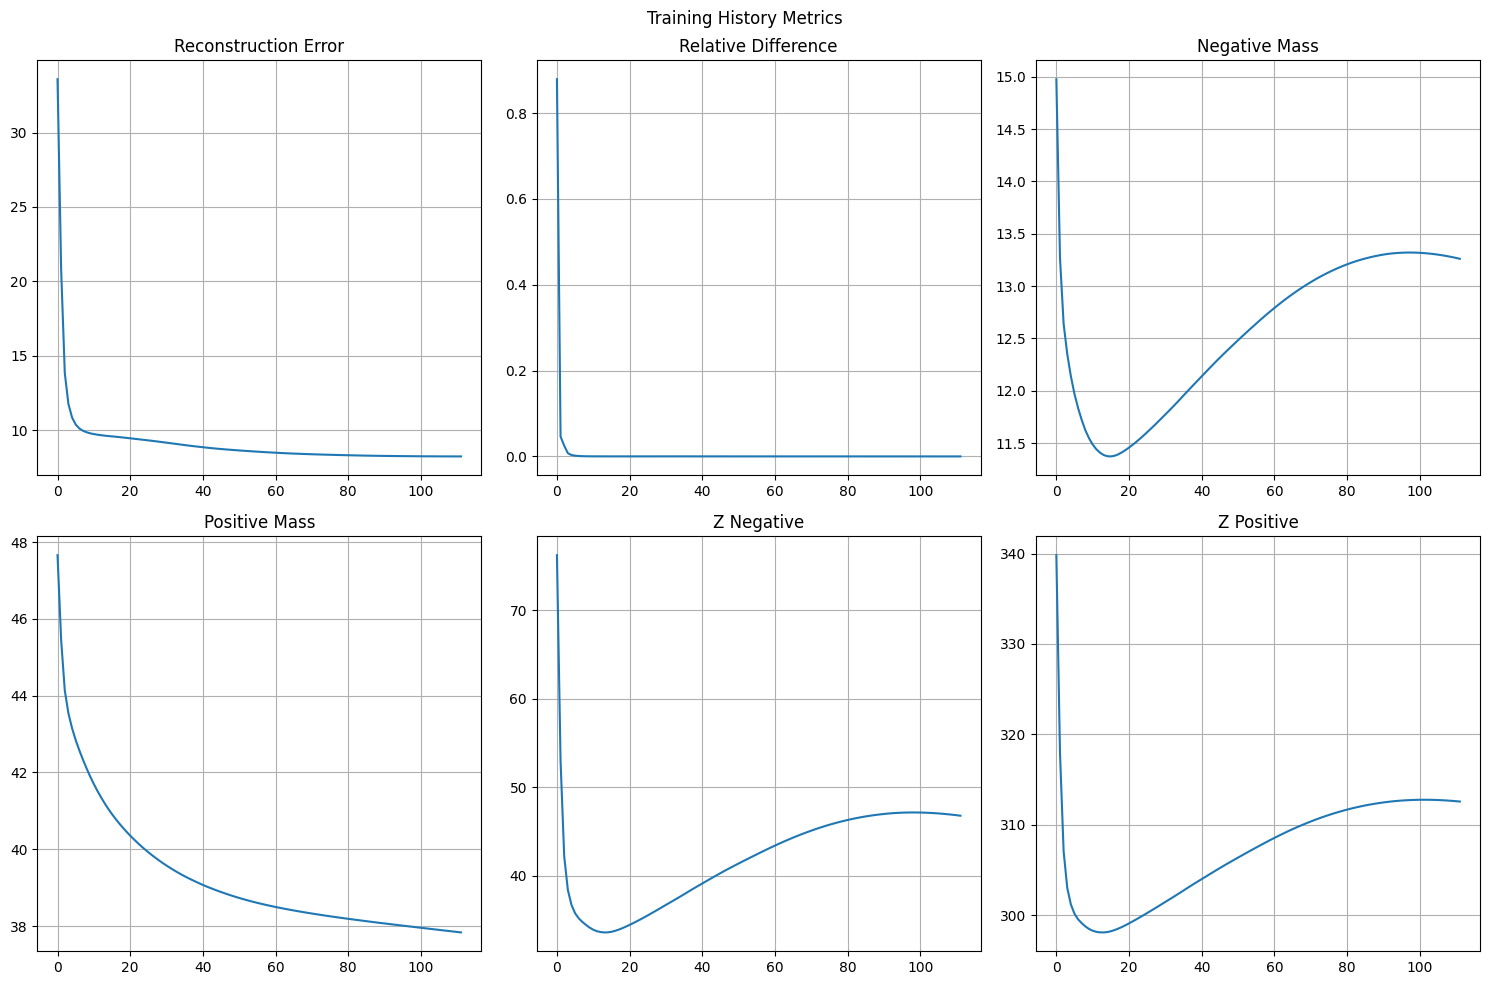

In [18]:
test = np.random.rand(100, 10)
s = test @ test.T

# if true, we simply project pos to be larger than neg after each iteration. if false, we use constrained NNLS.
projection_step = True

# regularization parameter of the asymmetric update. the larger, the closer w_pos and w_neg will be to each other.
# same for h_pos and h_neg.
alpha = 1.0


model = SymmetricMixed(
    rank=5, verbose=True, alpha=alpha, projection_step=projection_step
)
model.fit(s)
w = model.w_pos_ - model.w_neg_
history = model.history

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Training History Metrics")

# Plot each metric in its own subplot
metrics = [
    ("rec_error", "Reconstruction Error"),
    ("diff", "Relative Difference"),
    ("neg_mass", "Negative Mass"),
    ("pos_mass", "Positive Mass"),
    ("z_neg", "Z Negative"),
    ("z_pos", "Z Positive"),
]

for (metric, title), ax in zip(metrics, axes.flat):
    ax.plot(history[metric])
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()